In [1]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use({'figure.facecolor':'white'})

In [2]:
def read_input(filename):
    SystemDemand = pd.read_excel(filename, sheet_name = 'SystemDemand')
    NodeData = pd.read_excel(filename, sheet_name='NodeData')
    LineData = pd.read_excel(filename, sheet_name='LineData')

    return {'SystemDemand':SystemDemand, 'NodeData':NodeData, 'LineData':LineData}

In [3]:
data = read_input(r'Input_Files\InputData34.xlsx')
for i in data.keys():
    print(i, ':\n', data[i])
    print('\n')

SystemDemand :
     TIME    PD    QD
0      1  1.00  1.00
1      2  1.20  1.20
2      3  1.40  1.40
3      4  0.80  0.80
4      5  0.70  0.70
5      6  1.30  1.30
6      7  1.40  1.40
7      8  1.50  1.50
8      9  1.70  1.70
9     10  1.10  1.10
10    11  0.50  0.50
11    12  0.30  0.30
12    13  0.50  0.50
13    14  0.70  0.70
14    15  1.00  1.00
15    16  1.40  1.40
16    17  1.70  1.70
17    18  1.92  1.92
18    19  1.95  1.95
19    20  1.10  1.10
20    21  1.00  1.00
21    22  0.80  0.80
22    23  0.50  0.50
23    24  0.20  0.20


NodeData :
     NODES  Tb     PD    QD
0       1   1    0.0   0.0
1       2   0  130.3  80.7
2       3   0    0.0   0.0
3       4   0  130.3  80.7
4       5   0  130.3  80.7
5       6   0    0.0   0.0
6       7   0    0.0   0.0
7       8   0  130.3  80.7
8       9   0  130.3  80.7
9      10   0    0.0   0.0
10     11   0  130.3  80.7
11     12   0   77.6  47.6
12     13   0   40.8  25.5
13     14   0   40.8  25.5
14     15   0   40.8  25.5
15     16   0

In [4]:
def optimization_model(inputData, Vmax, Vmin, Vnom, Sbase, Zbase):

    SystemDemand= inputData['SystemDemand']
    NodeData = inputData['NodeData']
    LineData = inputData['LineData']
    time = [SystemDemand.loc[i, 'TIME'] for i in SystemDemand.index]
    lines = {(LineData.loc[i, 'FROM'], LineData.loc[i, 'TO']) for i in LineData.index}
    buses = [NodeData.loc[i, 'NODES'] for i in NodeData.index]
    R = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'R'] for i in LineData.index}
    X = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'X'] for i in LineData.index}
    B = {(LineData.loc[i,'FROM'],LineData.loc[i,'TO']):LineData.loc[i,'B'] for i in LineData.index}
    Tb = {buses[i]:NodeData.loc[i, 'Tb'] for i in NodeData.index}
    Pd = {(buses[i], time[k]):NodeData.loc[i, 'PD']*SystemDemand.loc[k, 'PD']/Sbase for k in SystemDemand.index for i in NodeData.index}
    Qd = {(buses[i], time[k]):NodeData.loc[i, 'QD']*SystemDemand.loc[k, 'QD']/Sbase for k in SystemDemand.index for i in NodeData.index}


    Ibase = Sbase/Vnom
    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    model = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------
    model.LINES = Set(initialize=lines)
    model.NODES = Set(initialize=buses)
    model.TIME = Set(ordered=True, initialize=time)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    model.R = Param(model.LINES, initialize=R, mutable=True, within=NonNegativeReals)
    model.X = Param(model.LINES, initialize=X, mutable=True, within=NonNegativeReals)
    model.B = Param(model.LINES, initialize=B, mutable=True, within=NonNegativeReals)

    model.Pd = Param(model.NODES, model.TIME, initialize=Pd, mutable=True, within=Any)
    model.Qd = Param(model.NODES, model.TIME, initialize=Qd, mutable=True, within=Any)
    model.Tb = Param(model.NODES, initialize=Tb, mutable=True, within=Any)
    model.Vmax = Param(initialize=Vmax, mutable=True) # p.u.
    model.Vmin = Param(initialize=Vmin, mutable=True) # p.u.
    model.Vnom = Param(initialize=1.0, mutable=True)  # p.u.

    #---------------------------------------------------------------------------------------------------------
    #Initialize Parameters
    #---------------------------------------------------------------------------------------------------------

    def ini_resistance(model, i,j):
        return model.R[i,j]/Zbase
    model.RM = Param(model.LINES, rule=ini_resistance)  # p.u.
    def ini_reactance(model, i,j):
        return model.X[i,j]/Zbase
    model.XM = Param(model.LINES, rule=ini_reactance)   # p.u.
    def ini_susceptance(model, i,j):
        return model.B[i,j]
    model.BM = Param(model.LINES, rule=ini_susceptance) # p.u.

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    model.I = Var(model.LINES, model.TIME, initialize=0)
    model.P = Var(model.LINES, model.TIME, initialize=0)
    model.Q = Var(model.LINES, model.TIME, initialize=0)

    def active_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Ps[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Ps = Var(model.NODES, model.TIME, initialize=active_supply_rule)

    def reactive_supply_rule(model, n, t):
        if model.Tb[n] == 0:
            temp = 0.0
            model.Qs[n,t].fixed = True
        else:
            temp = 0.0
        return temp
    model.Qs = Var(model.NODES, model.TIME, initialize=reactive_supply_rule)

    def ini_voltage(model, n, t):
        if model.Tb[n] == 0:
            temp = model.Vnom
            model.V[n,t].fixed = False
        else:
            temp = model.Vnom
            model.V[n,t].fixed = True
        return temp
    model.V = Var(model.NODES, model.TIME, initialize=ini_voltage)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def act_loss(model):
        return sum(model.RM[i,j]*(model.I[i,j,t]**2) for i,j in model.LINES for t in model.TIME)
    model.obj = Objective(rule=act_loss)

    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    def active_power_flow_rule(model, k, t):
        # Power_in + Power_supplied = Power_out + Power_out_lost + Power_consumed
        return sum(model.P[i,j,t] for i,j in model.LINES if j == k) + model.Ps[k,t] == \
               sum(model.P[i,j,t] + model.RM[i,j]*(model.I[i,j,t]**2) for i,j in model.LINES if i == k) + model.Pd[k,t]
    model.active_power_flow = Constraint(model.NODES, model.TIME, rule=active_power_flow_rule)

    def reactive_power_flow_rule(model, k, t):
        # Power_in + Power_supplied = Power_out + Power_out_lost + Power_consumed
        return sum(model.Q[i,j,t] + (model.V[j,t]**2)*model.BM[i,j]/2 for i,j in model.LINES if j == k) + model.Qs[k,t] == \
               sum(model.Q[i,j,t] + model.XM[i,j]*(model.I[i,j,t]**2) - (model.V[i,t]**2)*model.BM[i,j]/2 for i,j in model.LINES if i == k) + model.Qd[k,t]
    model.reactive_power_flow = Constraint(model.NODES, model.TIME, rule=reactive_power_flow_rule)

    def voltage_drop_rule(model, i, j, t):
        return (model.V[i,t]**2) - (model.V[j,t]**2) - 2*(model.RM[i,j]*model.P[i,j,t] + model.XM[i,j]*model.Q[i,j,t]) - (model.RM[i,j]**2 + model.XM[i,j]**2)*model.I[i,j,t]**2 == 0
    model.voltage_drop = Constraint(model.LINES, model.TIME, rule=voltage_drop_rule)

    def define_current_rule(model, i, j, t):
        return (model.V[j,t]**2)*(model.I[i,j,t]**2) == (model.P[i,j,t]**2)+(model.Q[i,j,t]**2)
    model.define_current = Constraint(model.LINES, model.TIME, rule=define_current_rule)

    def voltage_limit_rule(model, n, t):
        return inequality(model.Vmin, model.V[n,t], model.Vmax)
    model.voltage_limit = Constraint(model.NODES, model.TIME, rule=voltage_limit_rule)

    def current_limit_rule(model, i, j, t):
        return 0 <= model.I[i,j,t]
    model.current_limit = Constraint(model.LINES, model.TIME, rule=current_limit_rule)

    return model, buses, lines, Pd, Qd

In [5]:
Sbase = 1000 # kVA
Vnom = 11/np.sqrt(3)    # kV
Zbase = (Vnom**2)*1000/Sbase # Ohm
Vmax = 1.05
Vmin = 0.7
model, buses, lines, Pd, Qd = optimization_model(data, Vmax, Vmin, Vnom, Sbase, Zbase)
#model.pprint()

In [6]:
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    12696
Number of nonzeros in inequality constraint Jacobian.:     1584
Number of nonzeros in Lagrangian Hessian.............:     3960

Total number of variables............................:     3216
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4824, 'Number of variables': 3216, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.13\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.8646490573883057}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [7]:
# CHECK LOSSES+DEMAND=SUPPLY
losses = value(model.obj)
supply = sum([sum(value(model.Ps[n, t]) for n in model.NODES) for t in model.TIME])
demand = sum([sum(value(model.Pd[n, t]) for n in model.NODES) for t in model.TIME])
print([supply, demand, losses])
print([supply*Sbase, demand*Sbase, losses*Sbase, demand*Sbase + losses*Sbase])

[75.36399385588012, 67.427389, 7.936604855899383]
[75363.99385588012, 67427.38900000001, 7936.604855899383, 75363.99385589939]


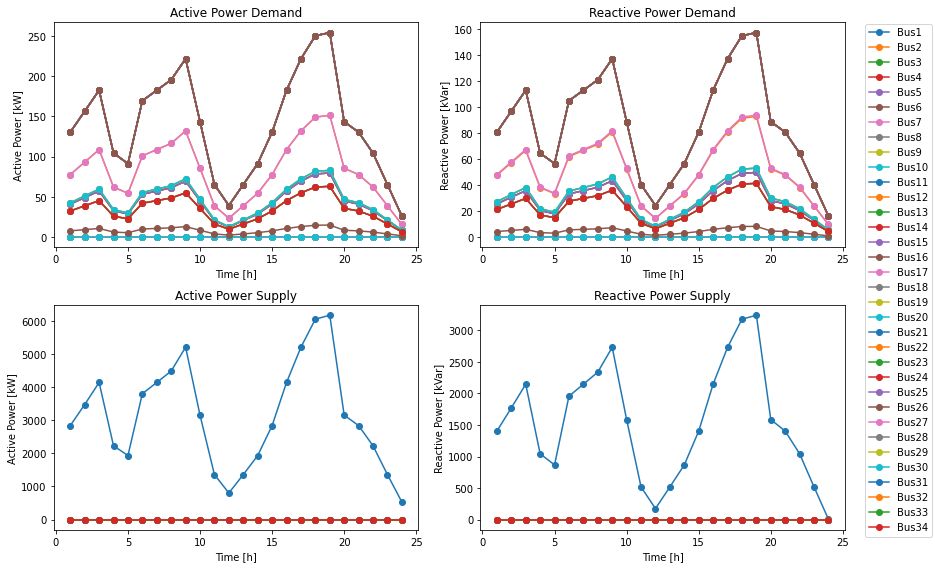

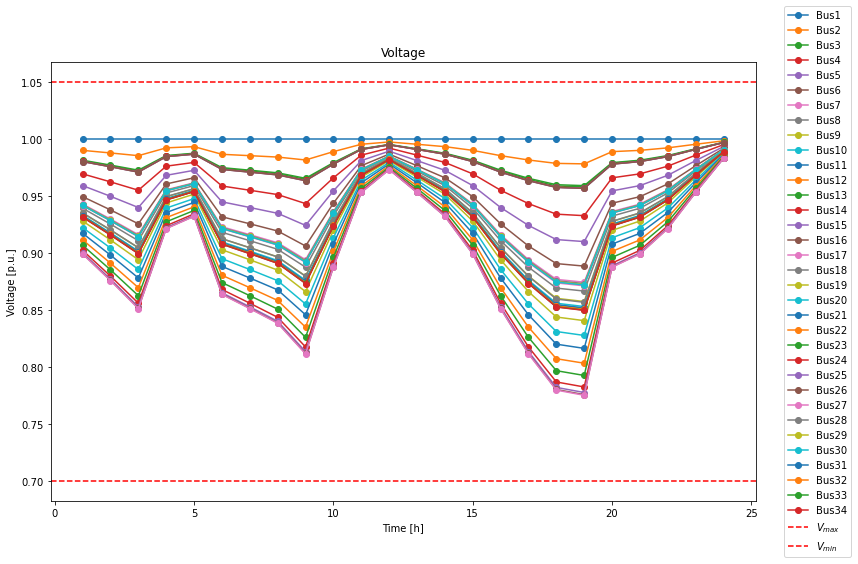

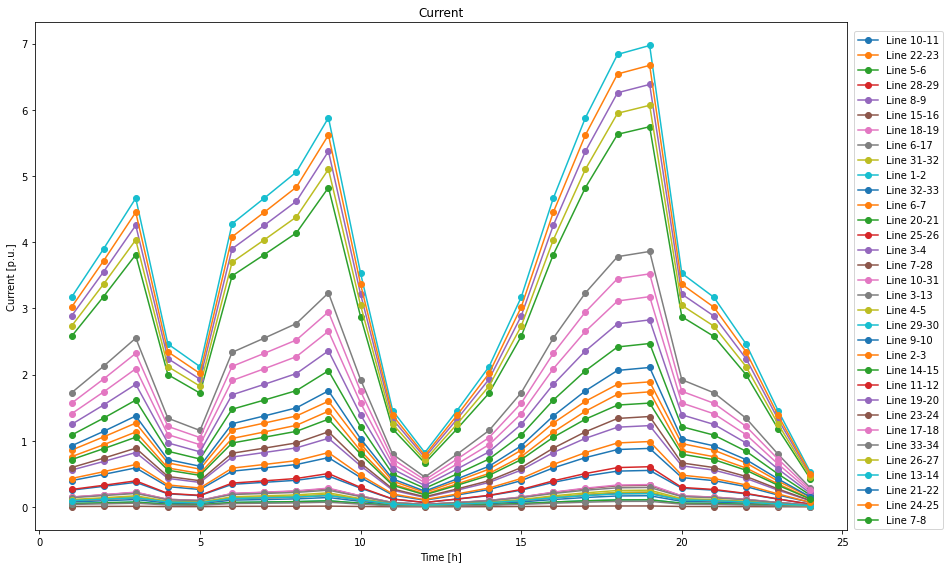

In [8]:
# DATA VISUALIZATION - VOLTAGES AND ACTIVE/REACTIVE POWERS AND CURRENTS/LOADING OF LINES
voltage = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
loading = pd.DataFrame(columns=lines, index=data['SystemDemand']['TIME'].values)
active_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_d = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
active_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
reactive_s = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)

for t in model.TIME:
    for n in model.NODES:
        voltage.loc[t,n] = model.V[n,t].value
        active_d.loc[t,n] = model.Pd[n,t].value*Sbase
        reactive_d.loc[t,n] = model.Qd[n,t].value*Sbase
        active_s.loc[t,n] = model.Ps[n,t].value*Sbase
        reactive_s.loc[t,n] = model.Qs[n,t].value*Sbase

for i,j in model.LINES:
    for t in model.TIME:
        loading.loc[t, pd.IndexSlice[i, j]] = model.I[i,j,t].value

fig_pow, ax_pow = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
ax_pow[0,0].plot(active_d.index, active_d, marker='o');ax_pow[0,0].set_xlabel('Time [h]');ax_pow[0,0].set_ylabel('Active Power [kW]');ax_pow[0,0].set_title('Active Power Demand');
ax_pow[0,1].plot(reactive_d.index, reactive_d, marker='o');ax_pow[0,1].set_xlabel('Time [h]');ax_pow[0,1].set_ylabel('Reactive Power [kVar]');ax_pow[0,1].set_title('Reactive Power Demand');
ax_pow[1,0].plot(active_s.index, active_s, marker='o');ax_pow[1,0].set_xlabel('Time [h]');ax_pow[1,0].set_ylabel('Active Power [kW]');ax_pow[1,0].set_title('Active Power Supply');
ax_pow[1,1].plot(reactive_s.index, reactive_s, marker='o');ax_pow[1,1].set_xlabel('Time [h]');ax_pow[1,1].set_ylabel('Reactive Power [kVar]');ax_pow[1,1].set_title('Reactive Power Supply');
fig_pow.legend(['Bus'+str(i) for i in active_d.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_pow.tight_layout()
fig_pow.show;
plt.savefig('power.png', bbox_inches='tight')

b=['Bus'+str(i) for i in active_d.columns]
b.extend({'$V_{min}$','$V_{max}$'})
fig_v, ax_v = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_v[0,0].plot(voltage.index, voltage, marker='o');ax_v[0,0].set_xlabel('Time [h]');ax_v[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
ax_v[0,0].axhline(model.Vmin.value, color='r', linestyle='--')
ax_v[0,0].axhline(model.Vmax.value, color='r', linestyle='--')
ax_v[0,0].legend(b, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
fig_v.tight_layout()
fig_v.show;
plt.savefig('voltage.png', bbox_inches='tight')

fig_i, ax_i = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
ax_i[0,0].plot(loading.index, loading, marker='o');ax_i[0,0].set_xlabel('Time [h]');ax_i[0,0].set_ylabel('Current [p.u.]');ax_i[0,0].set_title('Current');
fig_i.legend(['Line '+str(i)+'-'+str(j) for i,j in loading.columns], bbox_to_anchor=(1.04,0.5), loc='center', borderaxespad=0);
fig_i.tight_layout()
fig_i.show;
plt.savefig('current.png', bbox_inches='tight')

In [9]:
# voltage_wo = pd.DataFrame(columns=buses, index=data['SystemDemand']['TIME'].values)
#
# for t in model.TIME:
#     for n in model.NODES:
#         voltage_wo.loc[t,n] = model.V[n,t].value
#
# fig_vv, ax_vv = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(12,8))
# ax_vv[0,0].plot(voltage.index, voltage[27], marker='o', label='Bus27 - w shunt susceptance');ax_vv[0,0].set_xlabel('Time [h]');ax_vv[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
# ax_vv[0,0].plot(voltage_wo.index, voltage_wo[27], marker='o', label='Bus27 - wo shunt susceptance');ax_vv[0,0].set_xlabel('Time [h]');ax_vv[0,0].set_ylabel('Voltage [p.u.]');ax_v[0,0].set_title('Voltage');
# ax_vv[0,0].axhline(model.Vmin.value, color='r', linestyle='--')
# ax_vv[0,0].axhline(model.Vmax.value, color='r', linestyle='--')
# ax_vv[0,0].legend(bbox_to_anchor=(0.95,0.9), loc="best", borderaxespad=0)
# fig_vv.tight_layout()
# fig_vv.show;
# plt.savefig('voltage_comp.png', bbox_inches='tight')